# Implementing a simple two layers neural network
In this exercise we will develop a two neural network with fully-connected layers to perform classification, and test it out on the MNIST dataset.


In [50]:
"""
-----------------------------------------------------------------------------
A simple two layers neural network for handwritten digit classification (MNIST)
-----------------------------------------------------------------------------
AUTHOR: Soumitra Samanta (soumitra.samanta@gm.rkmvu.ac.in)
-----------------------------------------------------------------------------
"""

import gzip
import numpy as np
import matplotlib.pyplot as plt
import copy

from first_nn_sol import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read MNIST data:
You can download the data from [here](https://yann.lecun.com/exdb/mnist/). There are many [way](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python) you can read the MNIST data. Here is a [way](https://stackoverflow.com/a/62781370) to read all the information.

Train data (X) size: (60000, 28, 28), and labels (Y) size: (60000,)
Test data (X) size: (10000, 28, 28), and labels (Y) size: (10000,)


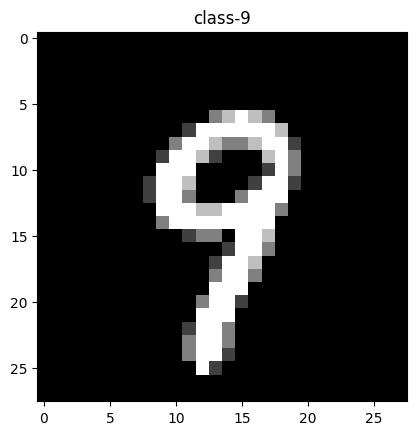

In [3]:
def read_images(filename):
    """Read MNIST images"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape((image_count, row_count, column_count))
        
    return images

def read_labels(filename):
    """Read MNIST labels"""
    
    with gzip.open(filename, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        
    return labels


dataset_path = '../../Assignment1/Assignment_1_a/'

train_image_filename = ''.join([dataset_path, 'train-images-idx3-ubyte.gz'])
train_label_filename = ''.join([dataset_path, 'train-labels-idx1-ubyte.gz'])

test_image_filename = ''.join([dataset_path, 't10k-images-idx3-ubyte.gz'])
test_label_filename = ''.join([dataset_path, 't10k-labels-idx1-ubyte.gz'])

train_images = read_images(train_image_filename)
train_labels = read_labels(train_label_filename)

print('Train data (X) size: {}, and labels (Y) size: {}' .format(train_images.shape, train_labels.shape))

test_images = read_images(test_image_filename)
test_labels = read_labels(test_label_filename)

print('Test data (X) size: {}, and labels (Y) size: {}' .format(test_images.shape, test_labels.shape))



rand_ids = np.random.choice(train_images.shape[0])
plt.imshow(train_images[rand_ids, :, :], cmap='gray')
plt.title('class-'+str(train_labels[rand_ids]))
plt.show()



In [51]:
import tarfile
import pickle
import numpy as np

# Path to the cifar-100-python.tar.gz file
cifar100_tar_path = 'cifar-100-python.tar.gz'

# Step 1: Extract the tar.gz file
with tarfile.open(cifar100_tar_path, 'r:gz') as tar:
    tar.extractall()

# Step 2: Load the dataset
def load_cifar100_batch(file):
    with open(file, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        # Extract images and labels
        images = data_dict[b'data']
        labels = data_dict[b'fine_labels']
        # CIFAR-100 images are in a flattened array, reshape to 32x32x3
        images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        labels = np.array(labels)
        return images, labels

# Load training data
train_images, train_labels = load_cifar100_batch('cifar-100-python/train')

# Load test data
test_images, test_labels = load_cifar100_batch('cifar-100-python/test')

print(f"Training data shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")




Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


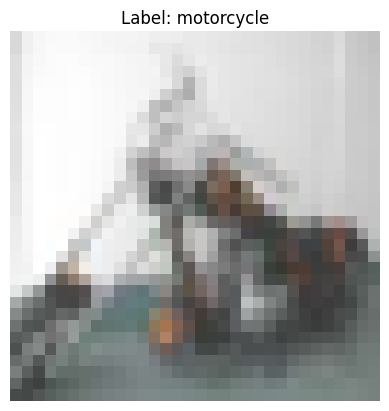

Label index: 48, Label name: motorcycle


In [52]:
import random
import pickle
import matplotlib.pyplot as plt

def load_meta(file):
    with open(file, 'rb') as f:
        meta_data = pickle.load(f, encoding='bytes')
        fine_label_names = meta_data[b'fine_label_names']
        fine_label_names = [label.decode('utf-8') for label in fine_label_names]
        return fine_label_names
    
label_names = load_meta('cifar-100-python/meta')

random_idx = random.randint(0, len(train_images) - 1)
random_image = train_images[random_idx]
random_label = train_labels[random_idx]
label_name = label_names[random_label]

plt.imshow(random_image)
plt.title(f"Label: {label_name}")
plt.axis('off')
plt.show()

print(f"Label index: {random_label}, Label name: {label_name}")


# TODO: Create a validation data from training data (10%) and transform the data in $\mathbf{R}^d$.

In [53]:
val_data_ration = 0.1 
class_ids = list(set(train_labels))
val_ids = []
for cl in class_ids:
    temp_val_index = np.where(train_labels == cl)[0]
    val_samples_count = round(temp_val_index.shape[0] * val_data_ration)
    val_ids.extend(list(np.random.permutation(temp_val_index)[:val_samples_count]))
# print(val_ids)
val_images = train_images[val_ids, :, :, :]
val_labels = train_labels[val_ids]

print('Validation data (X) size: {}, and labels (Y) size: {}' .format(val_images.shape, val_labels.shape))

train_ids = [i for i in range(train_labels.shape[0]) if i not in val_ids] 
revised_train_images = train_images[train_ids, :, :, :] 
revised_train_labels = train_labels[train_ids]
X_train = revised_train_images.reshape(revised_train_images.shape[0], -1)  
Y_train = revised_train_labels.reshape(-1)  
X_val = val_images.reshape(val_images.shape[0], -1)  
Y_val = val_labels.reshape(-1)  
X_test = test_images.reshape(test_images.shape[0], -1)  
Y_test = test_labels.reshape(-1)  

print('After reshape\n')
print('Train data (X) size: {}, and labels (Y) size: {}' .format(X_train.shape, Y_train.shape))
print('Val data (X) size: {}, and labels (Y) size: {}' .format(X_val.shape, Y_val.shape))
print('Test data (X) size: {}, and labels (Y) size: {}' .format(X_test.shape, Y_test.shape))


Validation data (X) size: (5000, 32, 32, 3), and labels (Y) size: (5000,)
After reshape

Train data (X) size: (45000, 3072), and labels (Y) size: (45000,)
Val data (X) size: (5000, 3072), and labels (Y) size: (5000,)
Test data (X) size: (10000, 3072), and labels (Y) size: (10000,)


# Train a network
To train our network we will use Stochastic Gradient Decent (SGD).

In [54]:
data_dimension = X_train.shape[1]
num_hidden_nodes = 50
num_classes = 100
net = FirstNN(data_dimension, num_hidden_nodes, num_classes)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=30,
                  batch_size=200, 
                  learning_rate=1e-2, 
                  verbose=True
                 )





Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.558827: 100%|██████████| 225/225 [00:02<00:00, 80.13it/s]


epoch: 1 / (30), loss: 4.589840, train acc: 2.22, val acc: 2.14
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.526649: 100%|██████████| 225/225 [00:03<00:00, 71.34it/s]


epoch: 2 / (30), loss: 4.545394, train acc: 2.36, val acc: 2.32
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.482877: 100%|██████████| 225/225 [00:03<00:00, 66.05it/s]


epoch: 3 / (30), loss: 4.506756, train acc: 2.79, val acc: 2.68
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.460596: 100%|██████████| 225/225 [00:03<00:00, 68.16it/s]


epoch: 4 / (30), loss: 4.473878, train acc: 3.01, val acc: 2.80
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.397924: 100%|██████████| 225/225 [00:03<00:00, 71.15it/s]


epoch: 5 / (30), loss: 4.445789, train acc: 2.89, val acc: 2.84
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.404684: 100%|██████████| 225/225 [00:03<00:00, 68.70it/s]


epoch: 6 / (30), loss: 4.420853, train acc: 3.38, val acc: 3.44
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.395871: 100%|██████████| 225/225 [00:03<00:00, 73.91it/s]


epoch: 7 / (30), loss: 4.397922, train acc: 4.38, val acc: 4.06
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.351154: 100%|██████████| 225/225 [00:02<00:00, 75.96it/s]


epoch: 8 / (30), loss: 4.376446, train acc: 4.86, val acc: 4.94
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.327865: 100%|██████████| 225/225 [00:03<00:00, 68.56it/s]


epoch: 9 / (30), loss: 4.356460, train acc: 4.94, val acc: 4.64
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 70 / (225), loss: 4.364642:  32%|███▏      | 71/225 [00:01<00:02, 69.36it/s]d:\x_MSC\3rd_sem\class\DL_NLP\Assignment1\Assignment_1_e\first_nn_sol.py:27: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
iteration: 224 / (225), loss: 4.279384: 100%|██████████| 225/225 [00:03<00:00, 68.71it/s]


epoch: 10 / (30), loss: 4.338947, train acc: 4.91, val acc: 4.80
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.314079: 100%|██████████| 225/225 [00:02<00:00, 77.85it/s]


epoch: 11 / (30), loss: 4.322770, train acc: 4.85, val acc: 4.86
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.318466: 100%|██████████| 225/225 [00:02<00:00, 75.66it/s]


epoch: 12 / (30), loss: 4.307404, train acc: 5.07, val acc: 5.20
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.295545: 100%|██████████| 225/225 [00:02<00:00, 77.78it/s]


epoch: 13 / (30), loss: 4.291498, train acc: 5.69, val acc: 5.30
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.239913: 100%|██████████| 225/225 [00:02<00:00, 81.71it/s]


epoch: 14 / (30), loss: 4.279564, train acc: 5.74, val acc: 5.76
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.327741: 100%|██████████| 225/225 [00:02<00:00, 80.01it/s]


epoch: 15 / (30), loss: 4.266676, train acc: 5.97, val acc: 5.88
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.293602: 100%|██████████| 225/225 [00:02<00:00, 80.45it/s]


epoch: 16 / (30), loss: 4.253925, train acc: 5.88, val acc: 5.70
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.275717: 100%|██████████| 225/225 [00:02<00:00, 78.65it/s]


epoch: 17 / (30), loss: 4.243536, train acc: 6.27, val acc: 6.00
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.211866: 100%|██████████| 225/225 [00:02<00:00, 77.54it/s]


epoch: 18 / (30), loss: 4.231728, train acc: 6.52, val acc: 6.26
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.238622: 100%|██████████| 225/225 [00:02<00:00, 77.77it/s]


epoch: 19 / (30), loss: 4.221859, train acc: 6.27, val acc: 6.26
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.272310: 100%|██████████| 225/225 [00:02<00:00, 76.03it/s]


epoch: 20 / (30), loss: 4.214107, train acc: 6.33, val acc: 6.28
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.309802: 100%|██████████| 225/225 [00:03<00:00, 74.69it/s]


epoch: 21 / (30), loss: 4.206676, train acc: 6.40, val acc: 6.30
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.197819: 100%|██████████| 225/225 [00:03<00:00, 66.65it/s]


epoch: 22 / (30), loss: 4.198796, train acc: 6.32, val acc: 6.16
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.214672: 100%|██████████| 225/225 [00:03<00:00, 59.85it/s]


epoch: 23 / (30), loss: 4.187689, train acc: 6.30, val acc: 6.14
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.258692: 100%|██████████| 225/225 [00:03<00:00, 67.96it/s]


epoch: 24 / (30), loss: 4.182560, train acc: 6.44, val acc: 6.42
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.166305: 100%|██████████| 225/225 [00:03<00:00, 67.21it/s]


epoch: 25 / (30), loss: 4.170666, train acc: 6.60, val acc: 6.02
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.198458: 100%|██████████| 225/225 [00:03<00:00, 72.61it/s]


epoch: 26 / (30), loss: 4.166007, train acc: 6.64, val acc: 6.66
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.195506: 100%|██████████| 225/225 [00:03<00:00, 72.55it/s]


epoch: 27 / (30), loss: 4.159430, train acc: 6.90, val acc: 6.64
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.241865: 100%|██████████| 225/225 [00:02<00:00, 77.58it/s]


epoch: 28 / (30), loss: 4.154762, train acc: 6.89, val acc: 6.44
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.189155: 100%|██████████| 225/225 [00:03<00:00, 74.88it/s]


epoch: 29 / (30), loss: 4.146524, train acc: 6.97, val acc: 7.04
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.106045: 100%|██████████| 225/225 [00:03<00:00, 74.63it/s]


epoch: 30 / (30), loss: 4.138123, train acc: 6.78, val acc: 6.54


In [55]:
# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))

Train accuracy: 6.97
Validation accuracy: 7.04
Test accuracy: 6.99


# Plot the loss.

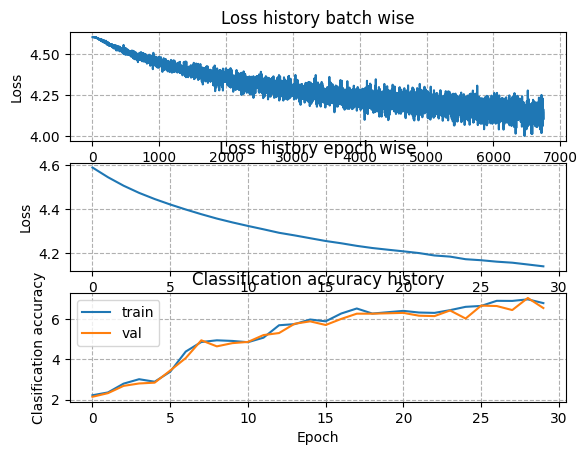

In [56]:
# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

# TODO: Tune your hyperparameters:
    - Learning rate:
    - Number of nodes in hidden layer:


In [57]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#################################################################################
results = {}
best_val = 0
best_net = None
learning_rates = [1e-3, 5e-3, 7e-3, 1e-2, 5e-2, 1e-1]
num_hidden_nodes = [30, 50, 60, 70, 100]
num_classes = 100
num_iters = 5000
num_epoch = 30
batch_size = 256
data_dimension = X_train.shape[1]

for nhn in num_hidden_nodes:
    for lr in learning_rates:
        
        net = FirstNN(data_dimension, nhn, num_classes)

        # Train the network
        stats = net.train(X_train, Y_train, X_val, Y_val, 
                          num_iters=num_iters,
                          num_epoch=num_epoch,
                          batch_size=batch_size, 
                          learning_rate=lr, 
                          verbose=False
                         )
            
        # Predict on the train set
        Y_train_pred = net.predict(X_train, best_param=True)
        train_acc = 100*(Y_train_pred == Y_train).mean()

        # Predict on the validation set
        Y_val_pred = net.predict(X_val, best_param=True)
        val_acc = 100*(Y_val_pred == Y_val).mean()

        results[(nhn, lr)] = (train_acc, val_acc)
        print('#hdnn: {}, lr: {} train accuracy: {:.2f} val accuracy: {:.2f}' .format(nhn, lr, train_acc, val_acc))
        if best_val < val_acc:
            best_val = val_acc
            best_net = copy.deepcopy(net)

# Print best results.
print('Best validation accuracy achieved during cross-validation: {:.2f} for #hdnn: {}, lr: {}' .format(best_val, best_net.best_params['W1'].shape[1], best_net.learning_rate))
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

#hdnn: 30, lr: 0.001 train accuracy: 4.94 val accuracy: 5.04
#hdnn: 30, lr: 0.005 train accuracy: 5.44 val accuracy: 5.16
#hdnn: 30, lr: 0.007 train accuracy: 5.10 val accuracy: 5.68
#hdnn: 30, lr: 0.01 train accuracy: 5.74 val accuracy: 5.96
#hdnn: 30, lr: 0.05 train accuracy: 6.21 val accuracy: 6.00
#hdnn: 30, lr: 0.1 train accuracy: 5.14 val accuracy: 4.96
#hdnn: 50, lr: 0.001 train accuracy: 4.97 val accuracy: 5.18
#hdnn: 50, lr: 0.005 train accuracy: 6.00 val accuracy: 6.06
#hdnn: 50, lr: 0.007 train accuracy: 6.54 val accuracy: 6.22
#hdnn: 50, lr: 0.01 train accuracy: 7.18 val accuracy: 6.76
#hdnn: 50, lr: 0.05 train accuracy: 6.73 val accuracy: 6.82
#hdnn: 50, lr: 0.1 train accuracy: 5.05 val accuracy: 4.90
#hdnn: 60, lr: 0.001 train accuracy: 5.37 val accuracy: 5.38
#hdnn: 60, lr: 0.005 train accuracy: 6.67 val accuracy: 6.42
#hdnn: 60, lr: 0.007 train accuracy: 7.15 val accuracy: 6.64
#hdnn: 60, lr: 0.01 train accuracy: 7.51 val accuracy: 7.28
#hdnn: 60, lr: 0.05 train accurac

# Test on best model

In [58]:
# Predict on the train set
Y_train_pred = best_net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = best_net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = best_net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))

Train accuracy: 8.94
Validation accuracy: 8.52
Test accuracy: 8.82


## TODO: Play with different initialization

## GD + Small_Std


Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.525348: 100%|██████████| 225/225 [00:03<00:00, 58.66it/s]


epoch: 1 / (30), loss: 4.575581, train acc: 3.49, val acc: 3.10
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.464314: 100%|██████████| 225/225 [00:03<00:00, 57.96it/s]


epoch: 2 / (30), loss: 4.494707, train acc: 4.34, val acc: 3.98
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.410906: 100%|██████████| 225/225 [00:03<00:00, 69.36it/s]


epoch: 3 / (30), loss: 4.433752, train acc: 5.15, val acc: 4.46
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.336760: 100%|██████████| 225/225 [00:03<00:00, 56.38it/s]


epoch: 4 / (30), loss: 4.388731, train acc: 5.45, val acc: 5.08
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.355916: 100%|██████████| 225/225 [00:03<00:00, 68.69it/s]


epoch: 5 / (30), loss: 4.352445, train acc: 5.45, val acc: 5.54
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.294009: 100%|██████████| 225/225 [00:04<00:00, 54.58it/s]


epoch: 6 / (30), loss: 4.320968, train acc: 5.56, val acc: 5.34
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.317847: 100%|██████████| 225/225 [00:03<00:00, 67.81it/s]


epoch: 7 / (30), loss: 4.294087, train acc: 6.19, val acc: 5.90
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.256227: 100%|██████████| 225/225 [00:03<00:00, 63.89it/s]


epoch: 8 / (30), loss: 4.269971, train acc: 6.17, val acc: 6.06
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.201851: 100%|██████████| 225/225 [00:03<00:00, 58.85it/s]


epoch: 9 / (30), loss: 4.249396, train acc: 6.54, val acc: 6.16
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.209294: 100%|██████████| 225/225 [00:07<00:00, 28.19it/s]


epoch: 10 / (30), loss: 4.229801, train acc: 6.63, val acc: 6.68
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.216704: 100%|██████████| 225/225 [00:04<00:00, 48.76it/s]


epoch: 11 / (30), loss: 4.214860, train acc: 6.74, val acc: 6.50
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.123937: 100%|██████████| 225/225 [00:03<00:00, 67.46it/s]


epoch: 12 / (30), loss: 4.197012, train acc: 6.79, val acc: 6.48
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.146917: 100%|██████████| 225/225 [00:04<00:00, 53.03it/s]


epoch: 13 / (30), loss: 4.180704, train acc: 7.14, val acc: 6.60
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.149742: 100%|██████████| 225/225 [00:03<00:00, 57.43it/s]


epoch: 14 / (30), loss: 4.168336, train acc: 6.78, val acc: 6.72
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.192050: 100%|██████████| 225/225 [00:03<00:00, 66.27it/s]


epoch: 15 / (30), loss: 4.157356, train acc: 6.95, val acc: 6.98
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.115747: 100%|██████████| 225/225 [00:03<00:00, 66.14it/s]


epoch: 16 / (30), loss: 4.145442, train acc: 6.84, val acc: 6.50
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.151417: 100%|██████████| 225/225 [00:03<00:00, 72.95it/s]


epoch: 17 / (30), loss: 4.134170, train acc: 7.30, val acc: 6.94
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.050409: 100%|██████████| 225/225 [00:02<00:00, 78.35it/s]


epoch: 18 / (30), loss: 4.124152, train acc: 7.49, val acc: 7.66
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.073472: 100%|██████████| 225/225 [00:02<00:00, 76.40it/s]


epoch: 19 / (30), loss: 4.117065, train acc: 7.14, val acc: 6.68
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.104563: 100%|██████████| 225/225 [00:02<00:00, 76.44it/s]


epoch: 20 / (30), loss: 4.106555, train acc: 7.92, val acc: 7.98
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.084375: 100%|██████████| 225/225 [00:03<00:00, 73.59it/s]


epoch: 21 / (30), loss: 4.099139, train acc: 7.85, val acc: 8.14
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.085124: 100%|██████████| 225/225 [00:03<00:00, 74.63it/s]


epoch: 22 / (30), loss: 4.090639, train acc: 8.03, val acc: 7.94
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.103573: 100%|██████████| 225/225 [00:02<00:00, 75.71it/s]


epoch: 23 / (30), loss: 4.083003, train acc: 8.29, val acc: 8.42
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.108930: 100%|██████████| 225/225 [00:02<00:00, 77.80it/s]


epoch: 24 / (30), loss: 4.076603, train acc: 8.30, val acc: 8.32
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.062255: 100%|██████████| 225/225 [00:02<00:00, 77.35it/s]


epoch: 25 / (30), loss: 4.067946, train acc: 8.36, val acc: 8.28
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.037063: 100%|██████████| 225/225 [00:02<00:00, 76.51it/s]


epoch: 26 / (30), loss: 4.063181, train acc: 8.69, val acc: 8.38
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.052596: 100%|██████████| 225/225 [00:02<00:00, 77.86it/s]


epoch: 27 / (30), loss: 4.058965, train acc: 8.63, val acc: 8.88
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.109629: 100%|██████████| 225/225 [00:02<00:00, 75.28it/s]


epoch: 28 / (30), loss: 4.048157, train acc: 8.94, val acc: 8.62
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.975495: 100%|██████████| 225/225 [00:03<00:00, 74.24it/s]


epoch: 29 / (30), loss: 4.043415, train acc: 9.32, val acc: 9.02
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.054309: 100%|██████████| 225/225 [00:02<00:00, 77.43it/s]


epoch: 30 / (30), loss: 4.036363, train acc: 9.21, val acc: 9.12
Train accuracy: 9.21
Validation accuracy: 9.12
Test accuracy: 8.99


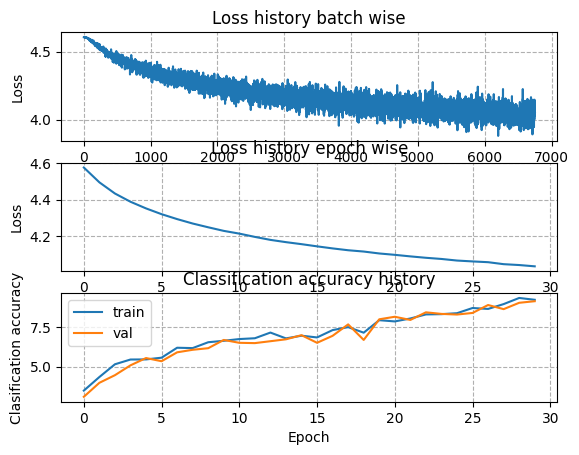

In [60]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200

param_init = 'small_std'



net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  verbose=True
                 )



# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## GD + Ninn_Std

Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.657994: 100%|██████████| 225/225 [00:03<00:00, 70.50it/s]


epoch: 1 / (30), loss: 4.683042, train acc: 1.04, val acc: 0.90
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.607505: 100%|██████████| 225/225 [00:03<00:00, 63.20it/s]


epoch: 2 / (30), loss: 4.628153, train acc: 0.98, val acc: 0.86
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.621125: 100%|██████████| 225/225 [00:03<00:00, 64.03it/s]


epoch: 3 / (30), loss: 4.611990, train acc: 1.16, val acc: 1.04
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.591217: 100%|██████████| 225/225 [00:03<00:00, 57.86it/s]


epoch: 4 / (30), loss: 4.605648, train acc: 1.63, val acc: 1.36
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.582097: 100%|██████████| 225/225 [00:03<00:00, 65.31it/s]


epoch: 5 / (30), loss: 4.604006, train acc: 1.26, val acc: 1.34
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.566843: 100%|██████████| 225/225 [00:03<00:00, 65.13it/s]


epoch: 6 / (30), loss: 4.595050, train acc: 1.81, val acc: 1.92
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603363: 100%|██████████| 225/225 [00:03<00:00, 67.00it/s]


epoch: 7 / (30), loss: 4.589958, train acc: 1.89, val acc: 1.68
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.587109: 100%|██████████| 225/225 [00:03<00:00, 67.11it/s]


epoch: 8 / (30), loss: 4.579151, train acc: 1.85, val acc: 2.16
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.590119: 100%|██████████| 225/225 [00:03<00:00, 66.78it/s]


epoch: 9 / (30), loss: 4.579847, train acc: 2.05, val acc: 2.00
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.549467: 100%|██████████| 225/225 [00:03<00:00, 67.06it/s]


epoch: 10 / (30), loss: 4.563246, train acc: 1.91, val acc: 1.90
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.568448: 100%|██████████| 225/225 [00:03<00:00, 65.38it/s]


epoch: 11 / (30), loss: 4.559759, train acc: 2.42, val acc: 2.00
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.529092: 100%|██████████| 225/225 [00:03<00:00, 66.93it/s]


epoch: 12 / (30), loss: 4.546147, train acc: 2.60, val acc: 3.10
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.504871: 100%|██████████| 225/225 [00:03<00:00, 68.13it/s]


epoch: 13 / (30), loss: 4.537345, train acc: 2.98, val acc: 3.08
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.542393: 100%|██████████| 225/225 [00:03<00:00, 61.90it/s]


epoch: 14 / (30), loss: 4.525826, train acc: 3.16, val acc: 3.26
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.510413: 100%|██████████| 225/225 [00:04<00:00, 51.45it/s]


epoch: 15 / (30), loss: 4.520336, train acc: 3.25, val acc: 2.74
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.514214: 100%|██████████| 225/225 [00:03<00:00, 59.78it/s]


epoch: 16 / (30), loss: 4.510440, train acc: 3.29, val acc: 3.06
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.509619: 100%|██████████| 225/225 [00:03<00:00, 63.20it/s]


epoch: 17 / (30), loss: 4.503675, train acc: 2.76, val acc: 2.44
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.477324: 100%|██████████| 225/225 [00:03<00:00, 62.76it/s]


epoch: 18 / (30), loss: 4.500749, train acc: 3.08, val acc: 2.68
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.476035: 100%|██████████| 225/225 [00:03<00:00, 62.95it/s]


epoch: 19 / (30), loss: 4.487131, train acc: 3.14, val acc: 2.88
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.484785: 100%|██████████| 225/225 [00:03<00:00, 65.68it/s]


epoch: 20 / (30), loss: 4.478332, train acc: 4.03, val acc: 3.88
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.429962: 100%|██████████| 225/225 [00:03<00:00, 65.59it/s]


epoch: 21 / (30), loss: 4.464838, train acc: 4.44, val acc: 4.02
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.434672: 100%|██████████| 225/225 [00:03<00:00, 63.92it/s]


epoch: 22 / (30), loss: 4.452474, train acc: 4.13, val acc: 3.98
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.431472: 100%|██████████| 225/225 [00:03<00:00, 64.33it/s]


epoch: 23 / (30), loss: 4.447428, train acc: 4.69, val acc: 4.36
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.445860: 100%|██████████| 225/225 [00:03<00:00, 65.23it/s]


epoch: 24 / (30), loss: 4.441197, train acc: 3.66, val acc: 3.66
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.420222: 100%|██████████| 225/225 [00:03<00:00, 63.88it/s]


epoch: 25 / (30), loss: 4.430955, train acc: 3.95, val acc: 3.68
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.444960: 100%|██████████| 225/225 [00:03<00:00, 66.56it/s]


epoch: 26 / (30), loss: 4.420570, train acc: 4.74, val acc: 4.60
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.392647: 100%|██████████| 225/225 [00:03<00:00, 67.59it/s]


epoch: 27 / (30), loss: 4.411123, train acc: 4.77, val acc: 4.38
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.394180: 100%|██████████| 225/225 [00:03<00:00, 66.79it/s]


epoch: 28 / (30), loss: 4.405962, train acc: 4.76, val acc: 4.66
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.365155: 100%|██████████| 225/225 [00:03<00:00, 63.17it/s]


epoch: 29 / (30), loss: 4.393133, train acc: 4.85, val acc: 5.00
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.372903: 100%|██████████| 225/225 [00:03<00:00, 65.54it/s]


epoch: 30 / (30), loss: 4.386383, train acc: 4.73, val acc: 4.40
Train accuracy: 4.85
Validation accuracy: 5.00
Test accuracy: 5.10


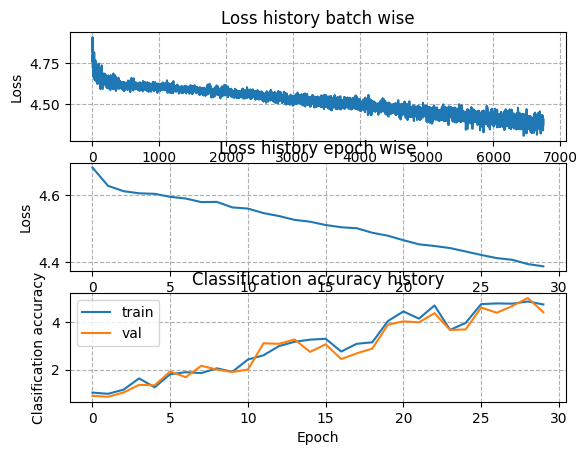

In [61]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200

param_init = 'ninn_std'



net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  verbose=True
                 )



# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## GD + Xavier

Xavier
Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.655911: 100%|██████████| 225/225 [00:03<00:00, 74.99it/s]


epoch: 1 / (30), loss: 4.690083, train acc: 1.00, val acc: 0.98
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603223: 100%|██████████| 225/225 [00:03<00:00, 74.16it/s]


epoch: 2 / (30), loss: 4.622272, train acc: 1.80, val acc: 1.60
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603110: 100%|██████████| 225/225 [00:03<00:00, 73.67it/s]


epoch: 3 / (30), loss: 4.600540, train acc: 1.75, val acc: 1.70
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.590822: 100%|██████████| 225/225 [00:03<00:00, 73.98it/s]


epoch: 4 / (30), loss: 4.592091, train acc: 1.35, val acc: 1.40
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.604300: 100%|██████████| 225/225 [00:03<00:00, 73.63it/s]


epoch: 5 / (30), loss: 4.589736, train acc: 1.24, val acc: 1.06
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.581236: 100%|██████████| 225/225 [00:03<00:00, 72.92it/s]


epoch: 6 / (30), loss: 4.587105, train acc: 1.84, val acc: 1.58
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.563341: 100%|██████████| 225/225 [00:03<00:00, 71.26it/s]


epoch: 7 / (30), loss: 4.578644, train acc: 2.22, val acc: 2.14
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.572474: 100%|██████████| 225/225 [00:03<00:00, 72.33it/s]


epoch: 8 / (30), loss: 4.563421, train acc: 2.08, val acc: 1.58
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.523235: 100%|██████████| 225/225 [00:03<00:00, 70.26it/s]


epoch: 9 / (30), loss: 4.552896, train acc: 2.58, val acc: 2.22
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.558684: 100%|██████████| 225/225 [00:02<00:00, 75.73it/s]


epoch: 10 / (30), loss: 4.551603, train acc: 2.71, val acc: 2.90
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.556103: 100%|██████████| 225/225 [00:03<00:00, 67.88it/s]


epoch: 11 / (30), loss: 4.540989, train acc: 3.10, val acc: 3.06
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.536411: 100%|██████████| 225/225 [00:03<00:00, 70.23it/s]


epoch: 12 / (30), loss: 4.530825, train acc: 2.58, val acc: 2.70
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.532368: 100%|██████████| 225/225 [00:03<00:00, 73.62it/s]


epoch: 13 / (30), loss: 4.519860, train acc: 3.48, val acc: 3.16
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.523549: 100%|██████████| 225/225 [00:03<00:00, 72.94it/s]


epoch: 14 / (30), loss: 4.512424, train acc: 3.33, val acc: 2.88
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.503075: 100%|██████████| 225/225 [00:03<00:00, 71.97it/s]


epoch: 15 / (30), loss: 4.501001, train acc: 3.54, val acc: 3.40
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.495500: 100%|██████████| 225/225 [00:03<00:00, 71.65it/s]


epoch: 16 / (30), loss: 4.490158, train acc: 4.11, val acc: 3.94
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.457957: 100%|██████████| 225/225 [00:03<00:00, 71.59it/s]


epoch: 17 / (30), loss: 4.481217, train acc: 4.08, val acc: 4.30
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.443769: 100%|██████████| 225/225 [00:03<00:00, 73.98it/s]


epoch: 18 / (30), loss: 4.464960, train acc: 4.21, val acc: 4.20
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.449614: 100%|██████████| 225/225 [00:03<00:00, 74.29it/s]


epoch: 19 / (30), loss: 4.461801, train acc: 4.12, val acc: 4.10
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.440852: 100%|██████████| 225/225 [00:03<00:00, 72.19it/s]


epoch: 20 / (30), loss: 4.452581, train acc: 3.72, val acc: 3.74
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.446313: 100%|██████████| 225/225 [00:03<00:00, 72.21it/s]


epoch: 21 / (30), loss: 4.444296, train acc: 4.43, val acc: 3.98
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.413879: 100%|██████████| 225/225 [00:03<00:00, 72.98it/s]


epoch: 22 / (30), loss: 4.433800, train acc: 4.53, val acc: 4.14
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.445470: 100%|██████████| 225/225 [00:03<00:00, 71.26it/s]


epoch: 23 / (30), loss: 4.420025, train acc: 4.45, val acc: 3.98
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.379928: 100%|██████████| 225/225 [00:03<00:00, 74.33it/s]


epoch: 24 / (30), loss: 4.411743, train acc: 4.77, val acc: 4.22
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.390603: 100%|██████████| 225/225 [00:03<00:00, 68.44it/s]


epoch: 25 / (30), loss: 4.395832, train acc: 4.92, val acc: 4.26
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.393388: 100%|██████████| 225/225 [00:03<00:00, 71.32it/s]


epoch: 26 / (30), loss: 4.391410, train acc: 5.00, val acc: 4.90
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.365728: 100%|██████████| 225/225 [00:03<00:00, 73.04it/s]


epoch: 27 / (30), loss: 4.378987, train acc: 4.93, val acc: 4.48
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.377538: 100%|██████████| 225/225 [00:03<00:00, 73.37it/s]


epoch: 28 / (30), loss: 4.376465, train acc: 4.98, val acc: 4.24
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.378878: 100%|██████████| 225/225 [00:03<00:00, 72.59it/s]


epoch: 29 / (30), loss: 4.362792, train acc: 4.78, val acc: 4.46
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.316902: 100%|██████████| 225/225 [00:03<00:00, 71.94it/s]


epoch: 30 / (30), loss: 4.360186, train acc: 5.08, val acc: 4.22
Train accuracy: 5.00
Validation accuracy: 4.90
Test accuracy: 4.60


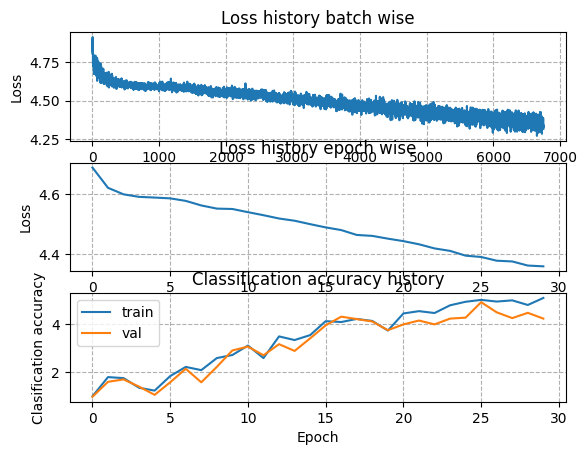

In [62]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200

param_init = 'Xavier'



net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  verbose=True
                 )



# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## MGD + Small_Std

Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.531390: 100%|██████████| 225/225 [00:03<00:00, 64.52it/s]


epoch: 1 / (30), loss: 4.571768, train acc: 3.46, val acc: 3.44
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.462539: 100%|██████████| 225/225 [00:03<00:00, 65.32it/s]


epoch: 2 / (30), loss: 4.485182, train acc: 4.14, val acc: 4.06
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.402473: 100%|██████████| 225/225 [00:03<00:00, 66.00it/s]


epoch: 3 / (30), loss: 4.421257, train acc: 4.59, val acc: 4.48
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.336298: 100%|██████████| 225/225 [00:03<00:00, 65.79it/s]


epoch: 4 / (30), loss: 4.372611, train acc: 4.99, val acc: 5.02
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.363196: 100%|██████████| 225/225 [00:04<00:00, 53.88it/s]


epoch: 5 / (30), loss: 4.332806, train acc: 5.64, val acc: 5.56
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.283805: 100%|██████████| 225/225 [00:04<00:00, 55.28it/s]


epoch: 6 / (30), loss: 4.298922, train acc: 6.08, val acc: 5.86
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.232940: 100%|██████████| 225/225 [00:03<00:00, 64.82it/s]


epoch: 7 / (30), loss: 4.271744, train acc: 6.03, val acc: 5.78
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.270463: 100%|██████████| 225/225 [00:03<00:00, 63.28it/s]


epoch: 8 / (30), loss: 4.246894, train acc: 6.56, val acc: 6.40
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.236228: 100%|██████████| 225/225 [00:03<00:00, 64.36it/s]


epoch: 9 / (30), loss: 4.225141, train acc: 6.35, val acc: 6.28
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.220231: 100%|██████████| 225/225 [00:03<00:00, 65.58it/s]


epoch: 10 / (30), loss: 4.205256, train acc: 6.43, val acc: 6.46
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.215249: 100%|██████████| 225/225 [00:03<00:00, 64.90it/s]


epoch: 11 / (30), loss: 4.188238, train acc: 6.72, val acc: 6.74
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.158727: 100%|██████████| 225/225 [00:03<00:00, 64.72it/s]


epoch: 12 / (30), loss: 4.172997, train acc: 7.14, val acc: 6.84
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.131843: 100%|██████████| 225/225 [00:03<00:00, 65.78it/s]


epoch: 13 / (30), loss: 4.158645, train acc: 7.10, val acc: 6.92
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.146419: 100%|██████████| 225/225 [00:03<00:00, 66.17it/s]


epoch: 14 / (30), loss: 4.145903, train acc: 7.05, val acc: 6.68
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.121560: 100%|██████████| 225/225 [00:03<00:00, 65.96it/s]


epoch: 15 / (30), loss: 4.134639, train acc: 7.11, val acc: 6.80
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.140179: 100%|██████████| 225/225 [00:03<00:00, 64.58it/s]


epoch: 16 / (30), loss: 4.122604, train acc: 7.74, val acc: 7.56
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.096231: 100%|██████████| 225/225 [00:03<00:00, 66.16it/s]


epoch: 17 / (30), loss: 4.114258, train acc: 7.55, val acc: 7.64
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.112047: 100%|██████████| 225/225 [00:03<00:00, 65.30it/s]


epoch: 18 / (30), loss: 4.104018, train acc: 7.68, val acc: 7.52
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.142213: 100%|██████████| 225/225 [00:03<00:00, 65.37it/s]


epoch: 19 / (30), loss: 4.091838, train acc: 7.73, val acc: 7.34
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.088177: 100%|██████████| 225/225 [00:03<00:00, 60.14it/s]


epoch: 20 / (30), loss: 4.085407, train acc: 7.74, val acc: 7.48
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.054676: 100%|██████████| 225/225 [00:03<00:00, 64.81it/s]


epoch: 21 / (30), loss: 4.078041, train acc: 8.34, val acc: 8.30
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.043685: 100%|██████████| 225/225 [00:03<00:00, 65.14it/s]


epoch: 22 / (30), loss: 4.068686, train acc: 8.49, val acc: 8.66
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.107046: 100%|██████████| 225/225 [00:03<00:00, 66.19it/s]


epoch: 23 / (30), loss: 4.062867, train acc: 8.37, val acc: 8.30
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.048440: 100%|██████████| 225/225 [00:03<00:00, 66.79it/s]


epoch: 24 / (30), loss: 4.056430, train acc: 8.74, val acc: 8.74
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.057045: 100%|██████████| 225/225 [00:03<00:00, 64.76it/s]


epoch: 25 / (30), loss: 4.047722, train acc: 8.74, val acc: 8.24
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.965670: 100%|██████████| 225/225 [00:03<00:00, 64.82it/s]


epoch: 26 / (30), loss: 4.042273, train acc: 9.05, val acc: 8.58
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.097099: 100%|██████████| 225/225 [00:03<00:00, 64.85it/s]


epoch: 27 / (30), loss: 4.032593, train acc: 8.89, val acc: 9.08
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.102861: 100%|██████████| 225/225 [00:03<00:00, 64.79it/s]


epoch: 28 / (30), loss: 4.021744, train acc: 9.10, val acc: 9.16
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.994929: 100%|██████████| 225/225 [00:03<00:00, 65.01it/s]


epoch: 29 / (30), loss: 4.018505, train acc: 9.31, val acc: 9.04
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.991089: 100%|██████████| 225/225 [00:03<00:00, 64.81it/s]


epoch: 30 / (30), loss: 4.013740, train acc: 9.26, val acc: 9.06
Train accuracy: 9.10
Validation accuracy: 9.16
Test accuracy: 9.46


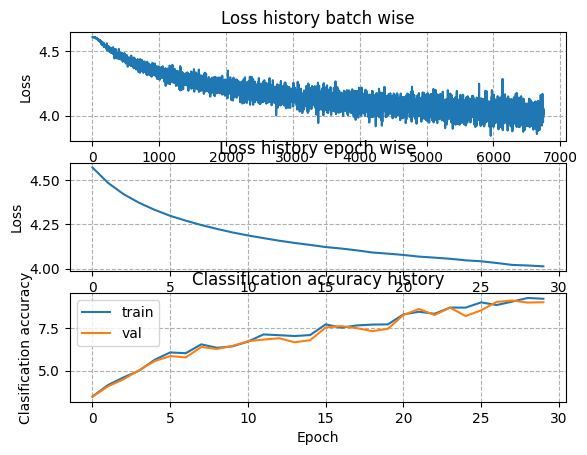

In [63]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'm_gd'

param_init = 'small_std'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## MGD + Ninn_Std

Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.656705: 100%|██████████| 225/225 [00:03<00:00, 66.38it/s]


epoch: 1 / (30), loss: 4.679192, train acc: 0.88, val acc: 0.94
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.618306: 100%|██████████| 225/225 [00:03<00:00, 64.99it/s]


epoch: 2 / (30), loss: 4.619840, train acc: 1.25, val acc: 1.28
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603135: 100%|██████████| 225/225 [00:04<00:00, 53.15it/s]


epoch: 3 / (30), loss: 4.613155, train acc: 1.72, val acc: 1.78
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.597300: 100%|██████████| 225/225 [00:04<00:00, 46.81it/s]


epoch: 4 / (30), loss: 4.606568, train acc: 0.88, val acc: 0.72
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603399: 100%|██████████| 225/225 [00:04<00:00, 47.57it/s]


epoch: 5 / (30), loss: 4.602684, train acc: 1.38, val acc: 1.24
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.605090: 100%|██████████| 225/225 [00:03<00:00, 64.69it/s]


epoch: 6 / (30), loss: 4.595814, train acc: 1.48, val acc: 1.34
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.567418: 100%|██████████| 225/225 [00:03<00:00, 66.06it/s]


epoch: 7 / (30), loss: 4.589135, train acc: 1.96, val acc: 2.12
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.590129: 100%|██████████| 225/225 [00:03<00:00, 69.62it/s]


epoch: 8 / (30), loss: 4.581745, train acc: 1.52, val acc: 1.48
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.574037: 100%|██████████| 225/225 [00:03<00:00, 66.19it/s]


epoch: 9 / (30), loss: 4.578276, train acc: 2.15, val acc: 2.34
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.591800: 100%|██████████| 225/225 [00:03<00:00, 65.89it/s]


epoch: 10 / (30), loss: 4.572104, train acc: 1.96, val acc: 2.02
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.554401: 100%|██████████| 225/225 [00:03<00:00, 64.84it/s]


epoch: 11 / (30), loss: 4.566559, train acc: 2.15, val acc: 2.30
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.534918: 100%|██████████| 225/225 [00:03<00:00, 65.08it/s]


epoch: 12 / (30), loss: 4.556185, train acc: 2.34, val acc: 2.22
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.545993: 100%|██████████| 225/225 [00:03<00:00, 64.87it/s]


epoch: 13 / (30), loss: 4.544480, train acc: 2.43, val acc: 2.36
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.533861: 100%|██████████| 225/225 [00:03<00:00, 65.98it/s]


epoch: 14 / (30), loss: 4.539085, train acc: 2.74, val acc: 2.70
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.556661: 100%|██████████| 225/225 [00:03<00:00, 62.76it/s]


epoch: 15 / (30), loss: 4.534202, train acc: 1.99, val acc: 2.06
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.526643: 100%|██████████| 225/225 [00:03<00:00, 65.35it/s]


epoch: 16 / (30), loss: 4.531211, train acc: 2.45, val acc: 2.48
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.523328: 100%|██████████| 225/225 [00:03<00:00, 64.55it/s]


epoch: 17 / (30), loss: 4.519490, train acc: 2.34, val acc: 2.16
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.479604: 100%|██████████| 225/225 [00:03<00:00, 65.08it/s]


epoch: 18 / (30), loss: 4.507562, train acc: 2.77, val acc: 2.66
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.514156: 100%|██████████| 225/225 [00:04<00:00, 48.42it/s]


epoch: 19 / (30), loss: 4.497643, train acc: 2.70, val acc: 2.54
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.485393: 100%|██████████| 225/225 [00:04<00:00, 50.80it/s]


epoch: 20 / (30), loss: 4.492248, train acc: 3.42, val acc: 3.14
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.453704: 100%|██████████| 225/225 [00:03<00:00, 60.38it/s]


epoch: 21 / (30), loss: 4.484425, train acc: 3.77, val acc: 3.44
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.441575: 100%|██████████| 225/225 [00:03<00:00, 58.81it/s]


epoch: 22 / (30), loss: 4.475560, train acc: 3.32, val acc: 3.22
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.484423: 100%|██████████| 225/225 [00:03<00:00, 60.90it/s]


epoch: 23 / (30), loss: 4.467533, train acc: 3.99, val acc: 3.68
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.446357: 100%|██████████| 225/225 [00:03<00:00, 64.56it/s]


epoch: 24 / (30), loss: 4.464306, train acc: 4.36, val acc: 3.82
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.425471: 100%|██████████| 225/225 [00:03<00:00, 65.48it/s]


epoch: 25 / (30), loss: 4.456478, train acc: 4.33, val acc: 4.12
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.403127: 100%|██████████| 225/225 [00:03<00:00, 59.58it/s]


epoch: 26 / (30), loss: 4.450833, train acc: 3.87, val acc: 3.72
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.454609: 100%|██████████| 225/225 [00:03<00:00, 64.26it/s]


epoch: 27 / (30), loss: 4.441016, train acc: 4.34, val acc: 3.84
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.438144: 100%|██████████| 225/225 [00:03<00:00, 65.33it/s]


epoch: 28 / (30), loss: 4.430887, train acc: 4.29, val acc: 4.12
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.461652: 100%|██████████| 225/225 [00:03<00:00, 65.58it/s]


epoch: 29 / (30), loss: 4.424191, train acc: 4.75, val acc: 4.36
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.388825: 100%|██████████| 225/225 [00:03<00:00, 64.54it/s]


epoch: 30 / (30), loss: 4.417728, train acc: 4.21, val acc: 4.18
Train accuracy: 4.75
Validation accuracy: 4.36
Test accuracy: 4.51


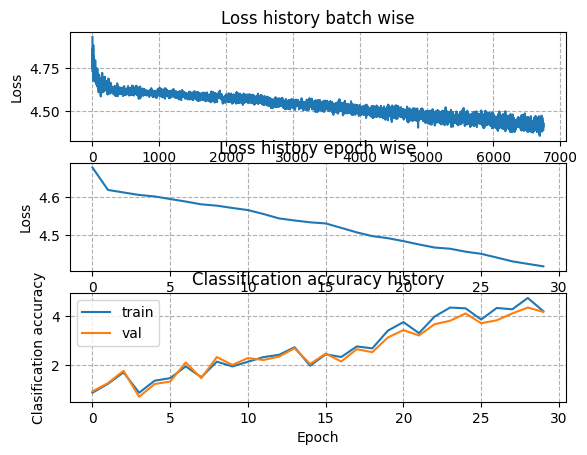

In [64]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'm_gd'

param_init = 'ninn_std'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## MGD + Xavier

Xavier
Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.614825: 100%|██████████| 225/225 [00:03<00:00, 66.49it/s]


epoch: 1 / (30), loss: 4.662531, train acc: 1.00, val acc: 1.00
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.597689: 100%|██████████| 225/225 [00:03<00:00, 64.56it/s]


epoch: 2 / (30), loss: 4.619846, train acc: 1.66, val acc: 1.74
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.642037: 100%|██████████| 225/225 [00:03<00:00, 66.20it/s]


epoch: 3 / (30), loss: 4.608235, train acc: 1.10, val acc: 0.96
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.579476: 100%|██████████| 225/225 [00:03<00:00, 66.08it/s]


epoch: 4 / (30), loss: 4.598405, train acc: 2.16, val acc: 1.70
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.588023: 100%|██████████| 225/225 [00:03<00:00, 65.44it/s]


epoch: 5 / (30), loss: 4.592259, train acc: 1.99, val acc: 1.82
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.574369: 100%|██████████| 225/225 [00:03<00:00, 66.76it/s]


epoch: 6 / (30), loss: 4.585585, train acc: 1.92, val acc: 1.50
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.559183: 100%|██████████| 225/225 [00:03<00:00, 67.78it/s]


epoch: 7 / (30), loss: 4.578258, train acc: 2.38, val acc: 2.12
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.566337: 100%|██████████| 225/225 [00:03<00:00, 66.79it/s]


epoch: 8 / (30), loss: 4.570071, train acc: 2.59, val acc: 2.32
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.577829: 100%|██████████| 225/225 [00:03<00:00, 65.18it/s]


epoch: 9 / (30), loss: 4.565171, train acc: 2.26, val acc: 2.26
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.572208: 100%|██████████| 225/225 [00:03<00:00, 66.46it/s]


epoch: 10 / (30), loss: 4.558340, train acc: 3.05, val acc: 2.82
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.595706: 100%|██████████| 225/225 [00:03<00:00, 66.17it/s]


epoch: 11 / (30), loss: 4.551653, train acc: 2.11, val acc: 1.70
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.533005: 100%|██████████| 225/225 [00:03<00:00, 66.70it/s]


epoch: 12 / (30), loss: 4.547726, train acc: 2.52, val acc: 2.30
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.535551: 100%|██████████| 225/225 [00:03<00:00, 67.74it/s]


epoch: 13 / (30), loss: 4.534459, train acc: 2.58, val acc: 2.56
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.500179: 100%|██████████| 225/225 [00:03<00:00, 67.30it/s]


epoch: 14 / (30), loss: 4.529068, train acc: 2.76, val acc: 2.72
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.504888: 100%|██████████| 225/225 [00:03<00:00, 66.69it/s]


epoch: 15 / (30), loss: 4.529444, train acc: 3.08, val acc: 2.98
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.522218: 100%|██████████| 225/225 [00:03<00:00, 66.42it/s]


epoch: 16 / (30), loss: 4.519389, train acc: 3.40, val acc: 3.20
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.483000: 100%|██████████| 225/225 [00:03<00:00, 65.05it/s]


epoch: 17 / (30), loss: 4.504967, train acc: 2.84, val acc: 2.78
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.489796: 100%|██████████| 225/225 [00:03<00:00, 65.67it/s]


epoch: 18 / (30), loss: 4.495431, train acc: 3.89, val acc: 3.96
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.483674: 100%|██████████| 225/225 [00:03<00:00, 66.19it/s]


epoch: 19 / (30), loss: 4.491808, train acc: 3.65, val acc: 3.12
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.473870: 100%|██████████| 225/225 [00:03<00:00, 65.87it/s]


epoch: 20 / (30), loss: 4.486217, train acc: 3.58, val acc: 3.16
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.477846: 100%|██████████| 225/225 [00:03<00:00, 65.01it/s]


epoch: 21 / (30), loss: 4.471407, train acc: 3.52, val acc: 3.10
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.439498: 100%|██████████| 225/225 [00:03<00:00, 66.58it/s]


epoch: 22 / (30), loss: 4.466391, train acc: 3.70, val acc: 3.72
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.449795: 100%|██████████| 225/225 [00:03<00:00, 66.46it/s]


epoch: 23 / (30), loss: 4.459069, train acc: 3.71, val acc: 3.64
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.484588: 100%|██████████| 225/225 [00:03<00:00, 67.10it/s]


epoch: 24 / (30), loss: 4.451238, train acc: 3.11, val acc: 2.86
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.429002: 100%|██████████| 225/225 [00:03<00:00, 65.91it/s]


epoch: 25 / (30), loss: 4.447101, train acc: 3.69, val acc: 3.48
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.471534: 100%|██████████| 225/225 [00:03<00:00, 67.02it/s]


epoch: 26 / (30), loss: 4.444952, train acc: 3.92, val acc: 3.94
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.447434: 100%|██████████| 225/225 [00:03<00:00, 66.70it/s]


epoch: 27 / (30), loss: 4.437857, train acc: 3.68, val acc: 3.92
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.441509: 100%|██████████| 225/225 [00:03<00:00, 66.31it/s]


epoch: 28 / (30), loss: 4.424300, train acc: 3.72, val acc: 3.58
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.455146: 100%|██████████| 225/225 [00:03<00:00, 65.09it/s]


epoch: 29 / (30), loss: 4.419524, train acc: 4.62, val acc: 4.22
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.434445: 100%|██████████| 225/225 [00:03<00:00, 66.14it/s]


epoch: 30 / (30), loss: 4.413242, train acc: 4.11, val acc: 4.22
Train accuracy: 4.62
Validation accuracy: 4.22
Test accuracy: 4.39


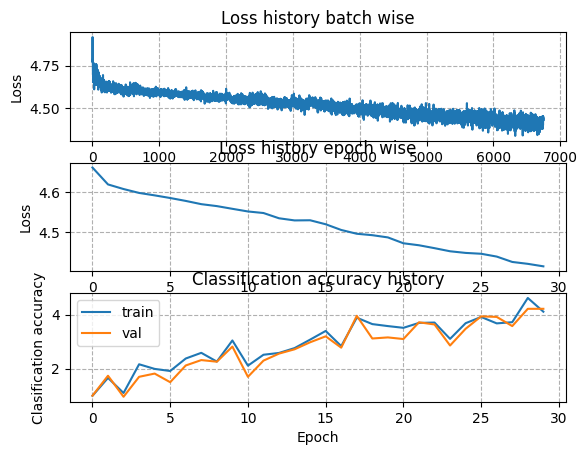

In [65]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'm_gd'

param_init = 'Xavier'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## NMGD + Small_std

Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.526120: 100%|██████████| 225/225 [00:03<00:00, 59.89it/s]


epoch: 1 / (30), loss: 4.567622, train acc: 2.78, val acc: 2.94
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.447532: 100%|██████████| 225/225 [00:03<00:00, 57.84it/s]


epoch: 2 / (30), loss: 4.473590, train acc: 3.40, val acc: 3.28
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.382904: 100%|██████████| 225/225 [00:04<00:00, 55.55it/s]


epoch: 3 / (30), loss: 4.405752, train acc: 4.57, val acc: 4.60
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.298258: 100%|██████████| 225/225 [00:04<00:00, 54.21it/s]


epoch: 4 / (30), loss: 4.356199, train acc: 5.10, val acc: 4.70
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.323045: 100%|██████████| 225/225 [00:03<00:00, 56.46it/s]


epoch: 5 / (30), loss: 4.315173, train acc: 5.57, val acc: 5.54
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.212350: 100%|██████████| 225/225 [00:03<00:00, 56.66it/s]


epoch: 6 / (30), loss: 4.283139, train acc: 6.08, val acc: 5.96
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.247163: 100%|██████████| 225/225 [00:03<00:00, 57.28it/s]


epoch: 7 / (30), loss: 4.253966, train acc: 6.11, val acc: 6.08
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.238112: 100%|██████████| 225/225 [00:03<00:00, 57.69it/s]


epoch: 8 / (30), loss: 4.230660, train acc: 6.21, val acc: 6.06
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.197121: 100%|██████████| 225/225 [00:03<00:00, 57.57it/s]


epoch: 9 / (30), loss: 4.209314, train acc: 6.48, val acc: 6.20
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.240963: 100%|██████████| 225/225 [00:03<00:00, 58.12it/s]


epoch: 10 / (30), loss: 4.189165, train acc: 6.43, val acc: 6.20
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.113938: 100%|██████████| 225/225 [00:03<00:00, 58.43it/s]


epoch: 11 / (30), loss: 4.172670, train acc: 6.61, val acc: 6.44
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.085755: 100%|██████████| 225/225 [00:03<00:00, 56.82it/s]


epoch: 12 / (30), loss: 4.158732, train acc: 7.09, val acc: 6.86
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.182540: 100%|██████████| 225/225 [00:04<00:00, 56.05it/s]


epoch: 13 / (30), loss: 4.145143, train acc: 6.80, val acc: 6.56
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.188364: 100%|██████████| 225/225 [00:03<00:00, 57.92it/s]


epoch: 14 / (30), loss: 4.130974, train acc: 7.15, val acc: 6.96
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.135940: 100%|██████████| 225/225 [00:03<00:00, 57.04it/s]


epoch: 15 / (30), loss: 4.119612, train acc: 7.32, val acc: 7.24
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.058921: 100%|██████████| 225/225 [00:03<00:00, 57.93it/s]


epoch: 16 / (30), loss: 4.108577, train acc: 7.23, val acc: 7.16
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.182657: 100%|██████████| 225/225 [00:03<00:00, 57.69it/s]


epoch: 17 / (30), loss: 4.100641, train acc: 7.76, val acc: 7.74
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.003992: 100%|██████████| 225/225 [00:03<00:00, 57.48it/s]


epoch: 18 / (30), loss: 4.096428, train acc: 7.96, val acc: 8.18
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.089966: 100%|██████████| 225/225 [00:03<00:00, 58.77it/s]


epoch: 19 / (30), loss: 4.086102, train acc: 8.32, val acc: 8.32
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.053863: 100%|██████████| 225/225 [00:03<00:00, 58.39it/s]


epoch: 20 / (30), loss: 4.080219, train acc: 8.12, val acc: 8.20
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.056883: 100%|██████████| 225/225 [00:03<00:00, 57.28it/s]


epoch: 21 / (30), loss: 4.066330, train acc: 8.42, val acc: 8.42
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.058675: 100%|██████████| 225/225 [00:03<00:00, 57.90it/s]


epoch: 22 / (30), loss: 4.057780, train acc: 8.78, val acc: 8.84
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.124911: 100%|██████████| 225/225 [00:03<00:00, 58.75it/s]


epoch: 23 / (30), loss: 4.053285, train acc: 8.94, val acc: 9.22
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.057357: 100%|██████████| 225/225 [00:03<00:00, 58.55it/s]


epoch: 24 / (30), loss: 4.050594, train acc: 9.09, val acc: 8.90
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.006305: 100%|██████████| 225/225 [00:03<00:00, 58.21it/s]


epoch: 25 / (30), loss: 4.040883, train acc: 9.10, val acc: 9.10
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.019044: 100%|██████████| 225/225 [00:03<00:00, 58.50it/s]


epoch: 26 / (30), loss: 4.026858, train acc: 9.49, val acc: 9.36
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.986989: 100%|██████████| 225/225 [00:04<00:00, 55.62it/s]


epoch: 27 / (30), loss: 4.022511, train acc: 9.37, val acc: 9.66
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.086060: 100%|██████████| 225/225 [00:03<00:00, 57.49it/s]


epoch: 28 / (30), loss: 4.015485, train acc: 9.88, val acc: 9.48
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.984185: 100%|██████████| 225/225 [00:03<00:00, 57.34it/s]


epoch: 29 / (30), loss: 4.010923, train acc: 9.63, val acc: 9.28
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 3.960720: 100%|██████████| 225/225 [00:03<00:00, 58.13it/s]


epoch: 30 / (30), loss: 4.001345, train acc: 9.24, val acc: 9.00
Train accuracy: 9.37
Validation accuracy: 9.66
Test accuracy: 9.30


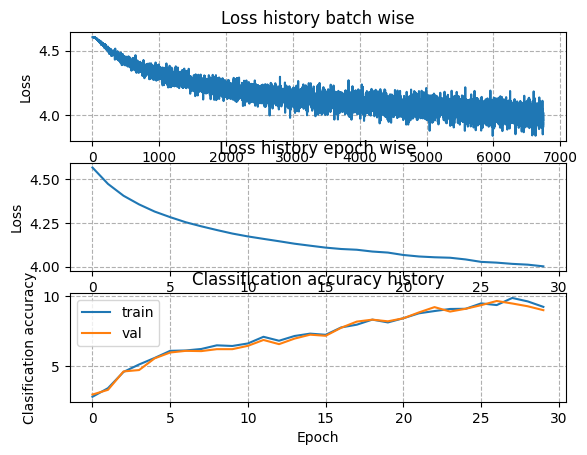

In [66]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'nm_gd'

param_init = 'small_std'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## NMGD + Ninn_std

Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.603625: 100%|██████████| 225/225 [00:03<00:00, 58.78it/s]


epoch: 1 / (30), loss: 4.678775, train acc: 0.56, val acc: 0.54
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.598633: 100%|██████████| 225/225 [00:03<00:00, 59.17it/s]


epoch: 2 / (30), loss: 4.622831, train acc: 1.75, val acc: 1.70
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.593827: 100%|██████████| 225/225 [00:04<00:00, 52.55it/s]


epoch: 3 / (30), loss: 4.610440, train acc: 1.51, val acc: 1.34
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.602504: 100%|██████████| 225/225 [00:03<00:00, 56.39it/s]


epoch: 4 / (30), loss: 4.607092, train acc: 1.37, val acc: 1.22
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.615496: 100%|██████████| 225/225 [00:04<00:00, 55.87it/s]


epoch: 5 / (30), loss: 4.602961, train acc: 1.42, val acc: 1.22
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.606787: 100%|██████████| 225/225 [00:03<00:00, 59.71it/s]


epoch: 6 / (30), loss: 4.600380, train acc: 1.12, val acc: 1.06
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.621068: 100%|██████████| 225/225 [00:03<00:00, 58.85it/s]


epoch: 7 / (30), loss: 4.599890, train acc: 1.71, val acc: 1.50
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.577872: 100%|██████████| 225/225 [00:04<00:00, 55.65it/s]


epoch: 8 / (30), loss: 4.593865, train acc: 1.78, val acc: 1.54
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.591130: 100%|██████████| 225/225 [00:03<00:00, 60.11it/s]


epoch: 9 / (30), loss: 4.593935, train acc: 2.09, val acc: 1.96
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.596363: 100%|██████████| 225/225 [00:03<00:00, 59.25it/s]


epoch: 10 / (30), loss: 4.594081, train acc: 1.07, val acc: 1.20
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.596666: 100%|██████████| 225/225 [00:03<00:00, 59.14it/s]


epoch: 11 / (30), loss: 4.586146, train acc: 1.97, val acc: 2.12
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.590828: 100%|██████████| 225/225 [00:03<00:00, 60.33it/s]


epoch: 12 / (30), loss: 4.581066, train acc: 1.99, val acc: 1.82
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.564091: 100%|██████████| 225/225 [00:03<00:00, 59.82it/s]


epoch: 13 / (30), loss: 4.581566, train acc: 1.99, val acc: 1.68
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.594992: 100%|██████████| 225/225 [00:03<00:00, 57.51it/s]


epoch: 14 / (30), loss: 4.571931, train acc: 1.92, val acc: 1.86
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.556855: 100%|██████████| 225/225 [00:03<00:00, 59.12it/s]


epoch: 15 / (30), loss: 4.568358, train acc: 2.32, val acc: 2.44
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.572587: 100%|██████████| 225/225 [00:03<00:00, 59.14it/s]


epoch: 16 / (30), loss: 4.565457, train acc: 2.08, val acc: 2.00
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.537925: 100%|██████████| 225/225 [00:03<00:00, 59.58it/s]


epoch: 17 / (30), loss: 4.555962, train acc: 2.61, val acc: 2.28
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.557152: 100%|██████████| 225/225 [00:03<00:00, 59.75it/s]


epoch: 18 / (30), loss: 4.554388, train acc: 2.71, val acc: 2.42
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.547384: 100%|██████████| 225/225 [00:04<00:00, 56.20it/s]


epoch: 19 / (30), loss: 4.544413, train acc: 3.06, val acc: 2.64
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.521594: 100%|██████████| 225/225 [00:03<00:00, 58.86it/s]


epoch: 20 / (30), loss: 4.533461, train acc: 2.24, val acc: 2.04
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.520496: 100%|██████████| 225/225 [00:03<00:00, 59.06it/s]


epoch: 21 / (30), loss: 4.528152, train acc: 3.22, val acc: 3.20
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.519523: 100%|██████████| 225/225 [00:03<00:00, 58.61it/s]


epoch: 22 / (30), loss: 4.521831, train acc: 2.80, val acc: 2.66
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.541965: 100%|██████████| 225/225 [00:03<00:00, 59.48it/s]


epoch: 23 / (30), loss: 4.514778, train acc: 3.04, val acc: 2.40
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.486216: 100%|██████████| 225/225 [00:03<00:00, 59.15it/s]


epoch: 24 / (30), loss: 4.503098, train acc: 3.82, val acc: 3.66
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.507584: 100%|██████████| 225/225 [00:03<00:00, 59.05it/s]


epoch: 25 / (30), loss: 4.495295, train acc: 3.27, val acc: 2.80
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.464730: 100%|██████████| 225/225 [00:03<00:00, 57.29it/s]


epoch: 26 / (30), loss: 4.493386, train acc: 3.67, val acc: 2.96
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.490293: 100%|██████████| 225/225 [00:03<00:00, 58.89it/s]


epoch: 27 / (30), loss: 4.479029, train acc: 3.06, val acc: 2.60
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.459974: 100%|██████████| 225/225 [00:03<00:00, 59.11it/s]


epoch: 28 / (30), loss: 4.469059, train acc: 3.01, val acc: 2.76
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.426547: 100%|██████████| 225/225 [00:03<00:00, 57.62it/s]


epoch: 29 / (30), loss: 4.462023, train acc: 4.02, val acc: 3.72
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.440837: 100%|██████████| 225/225 [00:03<00:00, 57.90it/s]


epoch: 30 / (30), loss: 4.454812, train acc: 3.88, val acc: 3.48
Train accuracy: 4.02
Validation accuracy: 3.72
Test accuracy: 4.18


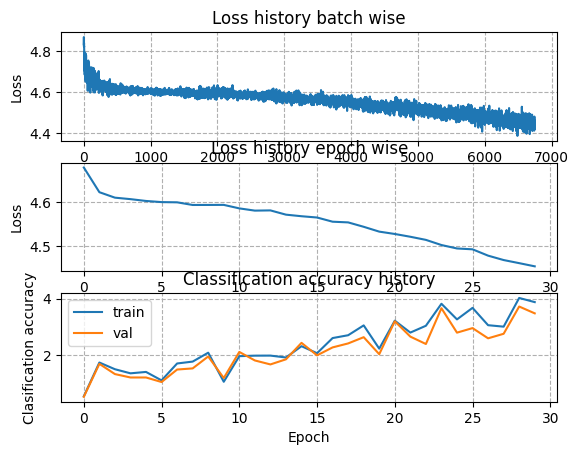

In [67]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'm_gd'

param_init = 'ninn_std'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()

## NMGD + Xavier

Xavier
Training epoch 1/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.604283: 100%|██████████| 225/225 [00:03<00:00, 60.83it/s]


epoch: 1 / (30), loss: 4.675161, train acc: 1.12, val acc: 1.10
Training epoch 2/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.605882: 100%|██████████| 225/225 [00:03<00:00, 59.48it/s]


epoch: 2 / (30), loss: 4.621452, train acc: 1.70, val acc: 1.62
Training epoch 3/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.601318: 100%|██████████| 225/225 [00:03<00:00, 58.68it/s]


epoch: 3 / (30), loss: 4.609013, train acc: 1.23, val acc: 1.00
Training epoch 4/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.596400: 100%|██████████| 225/225 [00:03<00:00, 58.78it/s]


epoch: 4 / (30), loss: 4.603825, train acc: 1.76, val acc: 1.76
Training epoch 5/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.605339: 100%|██████████| 225/225 [00:03<00:00, 58.93it/s]


epoch: 5 / (30), loss: 4.603119, train acc: 1.70, val acc: 1.56
Training epoch 6/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.587713: 100%|██████████| 225/225 [00:03<00:00, 56.98it/s]


epoch: 6 / (30), loss: 4.598635, train acc: 1.02, val acc: 0.96
Training epoch 7/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.601103: 100%|██████████| 225/225 [00:03<00:00, 57.95it/s]


epoch: 7 / (30), loss: 4.595380, train acc: 1.74, val acc: 1.52
Training epoch 8/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.584570: 100%|██████████| 225/225 [00:03<00:00, 58.41it/s]


epoch: 8 / (30), loss: 4.588268, train acc: 1.37, val acc: 1.18
Training epoch 9/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.574791: 100%|██████████| 225/225 [00:03<00:00, 58.78it/s]


epoch: 9 / (30), loss: 4.583170, train acc: 2.56, val acc: 2.04
Training epoch 10/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.585025: 100%|██████████| 225/225 [00:03<00:00, 57.28it/s]


epoch: 10 / (30), loss: 4.578633, train acc: 1.93, val acc: 2.00
Training epoch 11/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.591279: 100%|██████████| 225/225 [00:03<00:00, 58.41it/s]


epoch: 11 / (30), loss: 4.576411, train acc: 2.27, val acc: 2.44
Training epoch 12/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.554518: 100%|██████████| 225/225 [00:04<00:00, 54.90it/s]


epoch: 12 / (30), loss: 4.568806, train acc: 2.59, val acc: 2.46
Training epoch 13/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.552982: 100%|██████████| 225/225 [00:04<00:00, 54.29it/s]


epoch: 13 / (30), loss: 4.563911, train acc: 2.77, val acc: 2.46
Training epoch 14/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.525278: 100%|██████████| 225/225 [00:03<00:00, 57.03it/s]


epoch: 14 / (30), loss: 4.554443, train acc: 3.02, val acc: 3.06
Training epoch 15/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.552786: 100%|██████████| 225/225 [00:03<00:00, 58.59it/s]


epoch: 15 / (30), loss: 4.545563, train acc: 3.05, val acc: 2.78
Training epoch 16/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.516907: 100%|██████████| 225/225 [00:03<00:00, 59.43it/s]


epoch: 16 / (30), loss: 4.541441, train acc: 3.28, val acc: 3.12
Training epoch 17/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.553512: 100%|██████████| 225/225 [00:03<00:00, 58.49it/s]


epoch: 17 / (30), loss: 4.528588, train acc: 3.59, val acc: 3.64
Training epoch 18/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.514389: 100%|██████████| 225/225 [00:04<00:00, 52.07it/s]


epoch: 18 / (30), loss: 4.521806, train acc: 3.57, val acc: 3.54
Training epoch 19/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.493837: 100%|██████████| 225/225 [00:04<00:00, 55.19it/s]


epoch: 19 / (30), loss: 4.513930, train acc: 3.40, val acc: 3.02
Training epoch 20/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.522782: 100%|██████████| 225/225 [00:03<00:00, 57.61it/s]


epoch: 20 / (30), loss: 4.500924, train acc: 3.82, val acc: 3.40
Training epoch 21/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.533471: 100%|██████████| 225/225 [00:03<00:00, 57.55it/s]


epoch: 21 / (30), loss: 4.494544, train acc: 4.09, val acc: 3.78
Training epoch 22/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.500381: 100%|██████████| 225/225 [00:03<00:00, 56.60it/s]


epoch: 22 / (30), loss: 4.482717, train acc: 3.78, val acc: 3.66
Training epoch 23/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.470290: 100%|██████████| 225/225 [00:03<00:00, 56.44it/s]


epoch: 23 / (30), loss: 4.479118, train acc: 3.90, val acc: 3.60
Training epoch 24/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.447041: 100%|██████████| 225/225 [00:03<00:00, 57.43it/s]


epoch: 24 / (30), loss: 4.468771, train acc: 3.96, val acc: 3.78
Training epoch 25/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.440444: 100%|██████████| 225/225 [00:03<00:00, 59.89it/s]


epoch: 25 / (30), loss: 4.465074, train acc: 4.18, val acc: 3.84
Training epoch 26/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.496970: 100%|██████████| 225/225 [00:03<00:00, 58.48it/s]


epoch: 26 / (30), loss: 4.455228, train acc: 4.53, val acc: 4.30
Training epoch 27/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.394296: 100%|██████████| 225/225 [00:03<00:00, 58.88it/s]


epoch: 27 / (30), loss: 4.443075, train acc: 4.09, val acc: 3.66
Training epoch 28/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.414273: 100%|██████████| 225/225 [00:03<00:00, 59.85it/s]


epoch: 28 / (30), loss: 4.435192, train acc: 4.32, val acc: 4.52
Training epoch 29/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.435680: 100%|██████████| 225/225 [00:03<00:00, 59.77it/s]


epoch: 29 / (30), loss: 4.419378, train acc: 4.18, val acc: 4.36
Training epoch 30/(30)
----------------------------------------------------------------------


iteration: 224 / (225), loss: 4.416282: 100%|██████████| 225/225 [00:03<00:00, 59.30it/s]


epoch: 30 / (30), loss: 4.412840, train acc: 3.90, val acc: 3.60
Train accuracy: 4.32
Validation accuracy: 4.52
Test accuracy: 3.95


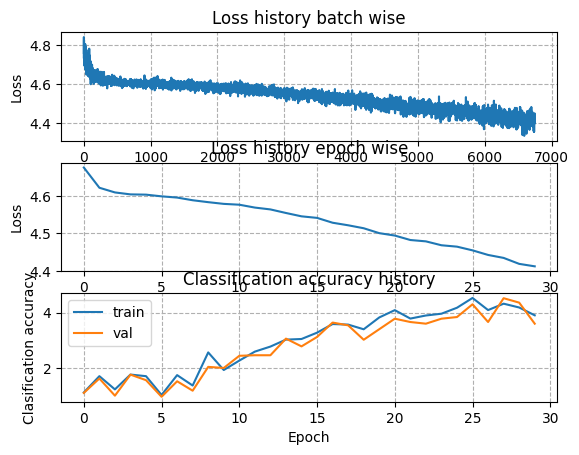

In [68]:
data_dimension = X_train.shape[1]
num_classes = 100

# Parameters
num_hidden_nodes = 100#best_net.best_params['W1'].shape[1]
learnin_rate = 0.01# best_net.learning_rate
num_epoch =  30
batch_size = 200
beta_moment = 1e-1
update_rule = 'm_gd'

param_init = 'Xavier'#'Xavier'# 'Xavier'#

net = FirstNN(data_dimension, num_hidden_nodes, num_classes, param_init=param_init)

# Train the network
stats = net.train(X_train, Y_train, X_val, Y_val, 
                  num_iters=10000,
                  num_epoch=num_epoch,
                  batch_size=batch_size, 
                  learning_rate=learnin_rate, 
                  beta_moment=beta_moment,
                  update_rule=update_rule,
                  verbose=True
                 )


# Predict on the train set
Y_train_pred = net.predict(X_train, best_param=True)
train_acc = 100*(Y_train_pred == Y_train).mean()
print('Train accuracy: {:.2f}' .format(train_acc))

# Predict on the validation set
Y_val_pred = net.predict(X_val, best_param=True)
val_acc = 100*(Y_val_pred == Y_val).mean()
print('Validation accuracy: {:.2f}' .format(val_acc))

# Predict on the test set
Y_test_pred = net.predict(X_test, best_param=True)
test_acc = 100*(Y_test_pred == Y_test).mean()
print('Test accuracy: {:.2f}' .format(test_acc))





# Plot the loss function and train / validation accuracies
plt.subplot(3, 1, 1)
plt.plot(stats['loss_history_batch'])
plt.title('Loss history batch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 2)
plt.plot(stats['loss_history_epoch'])
plt.title('Loss history epoch wise')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(linestyle='--')

plt.subplot(3, 1, 3)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.grid(linestyle='--')
plt.legend()
plt.show()